In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Ensures plots are displayed within the notebook
%matplotlib inline


In [2]:
def plot_function(func, xmin=-5, xmax=5, num_points=1000):
    """
    Plots a given function 'func' over the range [xmin, xmax].
    
    Parameters:
    func (function): The function to plot.
    xmin (float): The minimum value of x (default: -5).
    xmax (float): The maximum value of x (default: +5).
    num_points (int): Number of points to generate between xmin and xmax (default: 1000).
    """
    
    # Generate x values
    x_values = np.linspace(xmin, xmax, num_points)
    
    # Compute corresponding y values by applying the function to each x
    y_values = func(x_values)
    
    # Plot the function
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, label=f'Function: {func.__name__}')
    # plt.title(f'Plot of {func.__name__}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True)
    # plt.legend()
    plt.show()

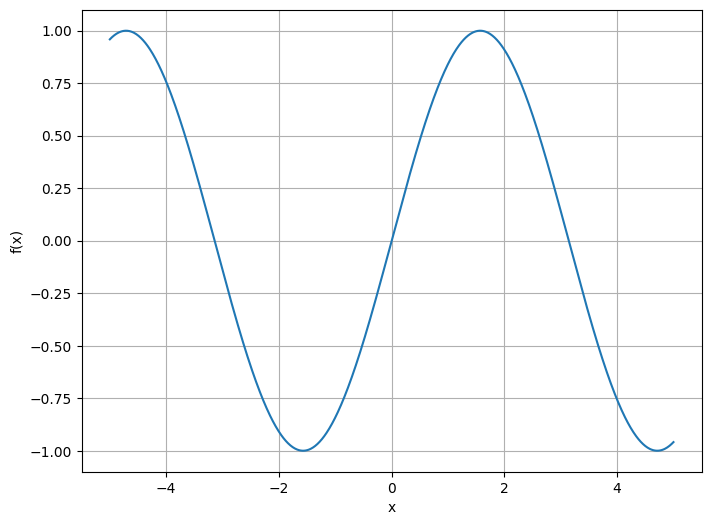

In [3]:
plot_function(np.sin)

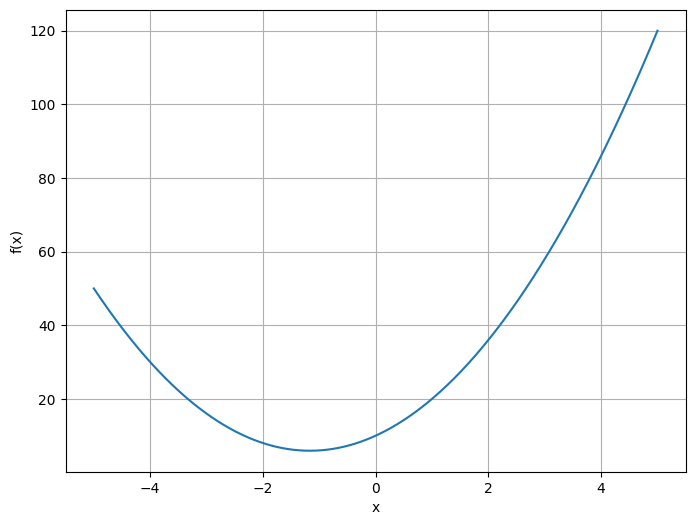

In [4]:
plot_function(lambda x: 3*x**2 + 7*x + 10)

# Micrograd building blocks

Building micrograd requires the follows:
- A `Value` class which handles individual numeric values.
- A `Neuron` class which handles an individual Neuron in the MLP
- A `Layer` class which handles an array of neurons
- A `MLP` class which handles the full MLP which is a concatenation of many `Layer` objects. 

## `Value` class

In [84]:
class Value:
    def __init__(self, value, pred=(), op='', label=''):
        self.value = value
        self._pred = pred
        self._op = op
        self.label = label
        self.grad = 0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Label: {self.label}, Value: {self.value:.4f}"
        
    def __add__(self, other):
        # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # Add the values
        res =  Value(self.value + other.value, pred = (self, other), op = '+')
        
        def _backward():
            self.grad += res.grad
            other.grad += res.grad

        res._backward = _backward

        return res

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
         # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # Sub the values
        res = self + -1*other
        return res

    def __rsub__(self, other):
         return -1*(self-other)

    def __mul__(self, other):
        # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # Mult the values
        res =  Value(self.value * other.value, pred = (self, other), op = '*')

        def _backward():
            self.grad += res.grad * other.value
            other.grad += res.grad * self.value

        res._backward = _backward

        return res

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # we want the power to be an integer/float
        res = Value(self.value**other, pred = (self,), op = f'**{other}')

        def _backward():
            self.grad += res.grad * other * self.value**(other - 1)

        res._backward = _backward

        return res

    def __truediv__(self, other):
         # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # Divide the values
        assert other.value != 0.0
        res = self.value * other.value**(-1)
        return Value(res, pred = (self, other), op = '/')

    def __rtruediv__(self, other):
        # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # now check add another condition if other.value is 0, otherwise reciprocal will throw error
        if other.value==0:
            return Value(0, pred = (other, self), op='/')
        return (self / other)**(-1)
    
    def relu(self):
        if self.value < 0:
            res = Value(0, pred=(self,), op='ReLU')
        else:
            res = Value(self.value, pred=(self,), op='ReLU')

        def _backward():
            self.grad += res.grad * (1 if self.value >= 0 else 0)

        res._backward = _backward

        return res
        
    def sigmoid(self):
        res = Value(1 / (1 + np.exp(-self.value)), pred=(self,), op='sigmoid')

        def _backward():
            self.grad += res.grad * (res.value * (1 - res.value))

        res._backward = _backward

        return res
    
    def tanh(self):
        res = Value((np.exp(self.value) - np.exp(-self.value))/(np.exp(self.value) + np.exp(-self.value)), pred=(self,), op='tanh')
        
        def _backward():
            self.grad += res.grad * (1 - res.value**2)

        res._backward = _backward

        return res
    
    def topo_sort(self):
        visited = set()
        topological_order  = []

        def dfs(node):
            visited.add(node)
            for child in node._pred:
                if child not in visited:
                    dfs(child)
            topological_order.append(node)

        dfs(self)

        return topological_order[::-1]
    
    def backward(self):
        topological_order = self.topo_sort()
        self.grad = 1
        for node in topological_order:
            node._backward()


In [11]:
a = Value(1, label='a')
b = Value(2.5, label='b')
c = Value(1.4, label='c')

## Graph visualisation

In [24]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._pred:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | value %.4f | grad %.4f}" % (n.label ,n.value, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

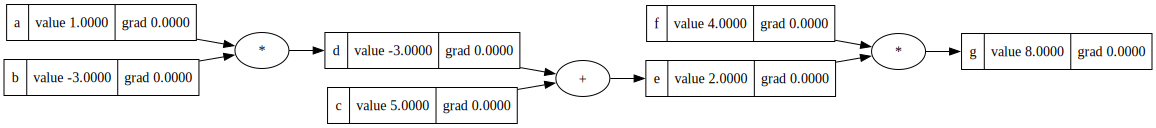

In [34]:
a = Value(1, label='a')
b = Value(-3, label='b')
c = Value(5, label='c')
d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(4, label='f')
g = e * f; g.label = 'g'
draw_dot(g)

## Manual grad calculation

Using formula

In [35]:
g.grad = 1
e.grad = g.grad * f.value
f.grad = g.grad * e.value
d.grad = e.grad
c.grad = e.grad
b.grad = d.grad * a.value 
a.grad = d.grad * b.value

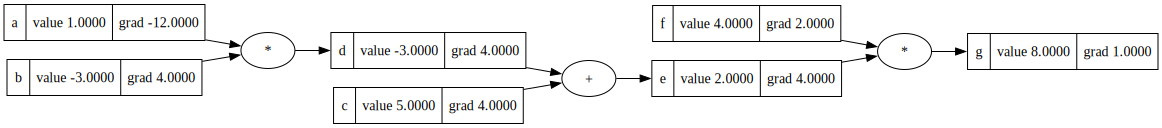

In [36]:
draw_dot(g)

Using a function and determining the movement using small changes

In [43]:
def grad_numeric():
    h = 0.0001
    a = Value(1, label='a')
    b = Value(-3, label='b')
    c = Value(5, label='c')
    d = a * b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(4, label='f')
    g = e * f; g.label = 'g'
    g1 = g.value

    a = Value(1, label='a')
    b = Value(-3, label='b')
    c = Value(5, label='c')
    d = a * b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(4 + h, label='f')
    g = e * f; g.label = 'g'
    g2 = g.value

    print((g2-g1)/h)

grad_numeric()

1.9999999999953388


Next, we can see the effect of the gradient to increase the value of g

In [44]:
## Increase leaf nodes a, b, c and f in direction of their gradients
a += 0.01 * a.grad
b += 0.01 * b.grad
c += 0.01 * c.grad
f += 0.01 * f.grad

d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
g = e * f; g.label = 'g'

g

Value: 9.7895

## Build a neuron and backpropagate through that

![Neuron image](./neuron.webp)

Lets create a simple 2 input neuron using the Value class

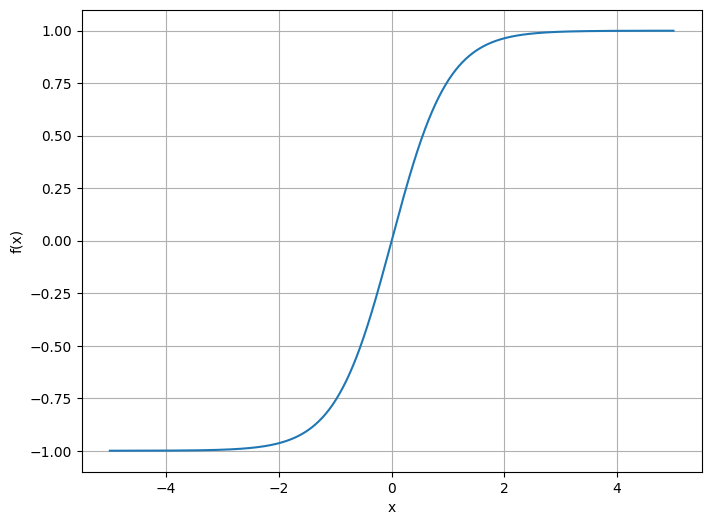

In [53]:
plot_function(np.tanh)

In [55]:
np.random.seed(42)

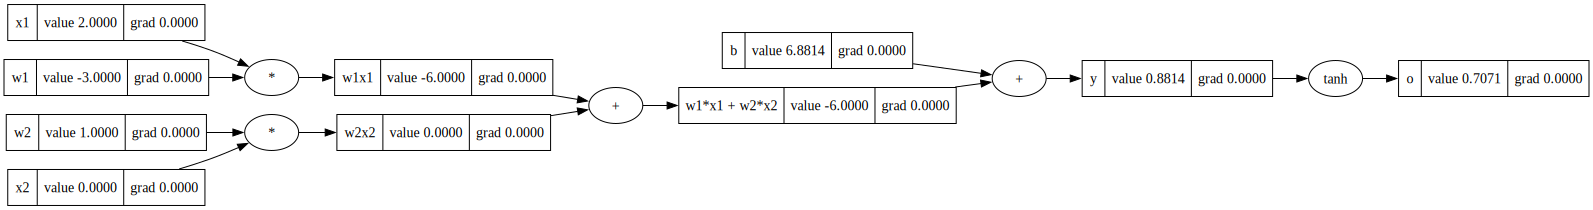

In [70]:
w1 = Value(-3.0, label='w1')
x1 = Value(2.0, label='x1')

w2 = Value(1.0, label='w2')
x2 = Value(0.0, label='x2')

b = Value(6.881373587, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"
y = w1x1w2x2 + b; y.label = 'y'
o = y.tanh(); o.label = 'o'
draw_dot(o)

Compute the gradients manually

In [67]:
o.grad = 1

y.grad = (1 - o.value**2) * o.grad

b.grad = y.grad
w1x1w2x2.grad = y.grad

w1x1.grad = w1x1w2x2.grad
w2x2.grad = w1x1w2x2.grad

w1.grad = w1x1.grad * x1.value
x1.grad = w1x1.grad * w1.value
w2.grad = w2x2.grad * x2.value
x2.grad = w2x2.grad * w2.value

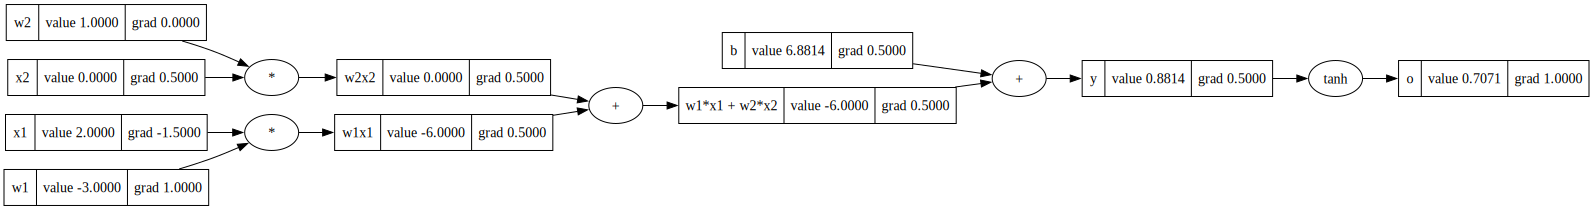

In [68]:
draw_dot(o)

Using the `_backward` function we defined

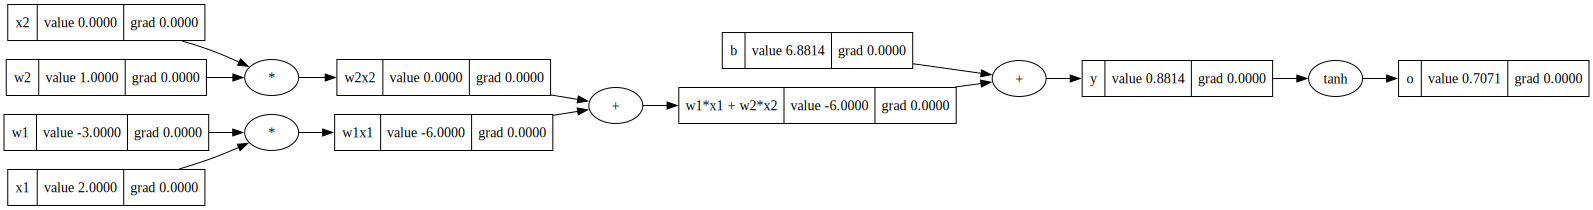

In [73]:
w1 = Value(-3.0, label='w1')
x1 = Value(2.0, label='x1')

w2 = Value(1.0, label='w2')
x2 = Value(0.0, label='x2')

b = Value(6.881373587, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"
y = w1x1w2x2 + b; y.label = 'y'
o = y.tanh(); o.label = 'o'
draw_dot(o)

In [76]:
o.grad = 1
o._backward()

y._backward()

w1x1w2x2._backward()
b._backward()

w1x1._backward()
w2x2._backward()

w1._backward()
x1._backward()
w2._backward()
x2._backward()

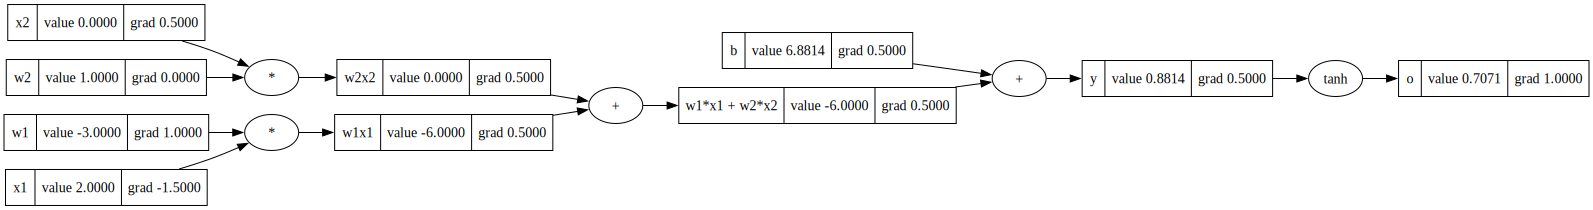

In [77]:
draw_dot(o)

## Implement a full fledged backward function

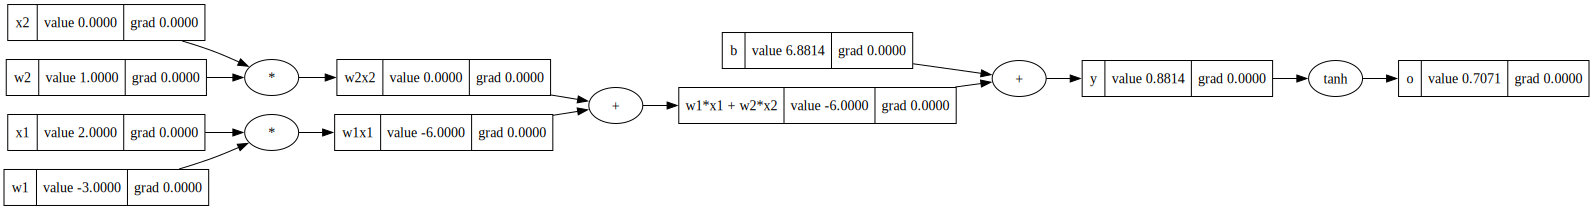

In [85]:
w1 = Value(-3.0, label='w1')
x1 = Value(2.0, label='x1')

w2 = Value(1.0, label='w2')
x2 = Value(0.0, label='x2')

b = Value(6.881373587, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"
y = w1x1w2x2 + b; y.label = 'y'
o = y.tanh(); o.label = 'o'
draw_dot(o)

In [86]:
o.topo_sort()

[Label: o, Value: 0.7071,
 Label: y, Value: 0.8814,
 Label: b, Value: 6.8814,
 Label: w1*x1 + w2*x2, Value: -6.0000,
 Label: w2x2, Value: 0.0000,
 Label: x2, Value: 0.0000,
 Label: w2, Value: 1.0000,
 Label: w1x1, Value: -6.0000,
 Label: x1, Value: 2.0000,
 Label: w1, Value: -3.0000]

In [87]:
o.backward()

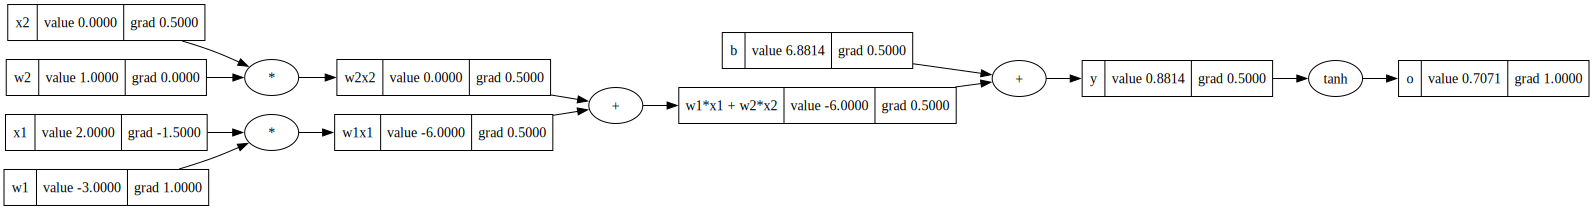

In [90]:
draw_dot(o)

Check edge case of repeated node

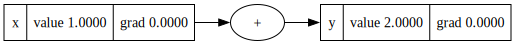

In [93]:
x = Value(1.0, label='x')
y = x + x; y.label = 'y'
draw_dot(y)

In [94]:
y.backward()

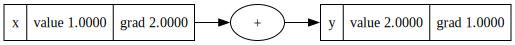

In [95]:
draw_dot(y)

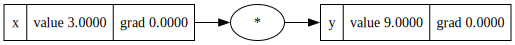

In [96]:
x = Value(3.0, label='x')
y = x * x; y.label = 'y'
draw_dot(y)

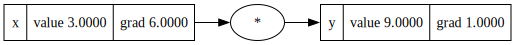

In [97]:
y.backward()
draw_dot(y)